In [1]:
INPUTS = ['production/global', 'production/puri/input', 'production/puri/modeloutput/rooftype']
OUTPUT = 'production/puri/modeloutput/riskscore'
REGION= 'puri'
UTM = 32645

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from osgeo import gdal, ogr, osr, gdalconst
from osgeo.gdalconst import *
import tempfile

import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import pyproj
import requests

from shapely.geometry import Point
from shapely.geometry import box
%matplotlib inline
from scipy.spatial import distance

import elevation
import os
import datetime
import re
from pathlib import Path
import overpy
import richdem as rd
import seaborn as sns
import rasterio.mask
import rasterio as rio
from rasterio import profiles
import utm 
from fiona.crs import from_epsg
import fiona 
import os
import subprocess
import yaml
from supermercado import burntiles
from rasterio.crs import CRS
import rioxarray as rxr

import rtree
import rasterstats
from tqdm import tqdm
from functools import reduce

In [6]:
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS', 'tif')
gdal.SetConfigOption('VSI_CACHE', 'TRUE')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN', 'TRUE')

In [7]:
WGS84 = 4326

In [8]:
#Setting path structure
RAW  = Path(INPUTS[1])
GLOBAL = Path(INPUTS[0])
FOOTPRINTS = Path(INPUTS[2])
RISKSCORE = Path(OUTPUT)

#create inter and output folder inside the output folder provided
INTER = RISKSCORE/'inter'
OUTPUT = RISKSCORE/'output'
CROPPED = RISKSCORE/'cropped'

os.makedirs(INTER, exist_ok=True)
os.makedirs(OUTPUT, exist_ok=True)
os.makedirs(CROPPED, exist_ok=True)

In [9]:
!echo 'test' >> {CROPPED}/test.txt
!ls {CROPPED}

test.txt


# Read AOI

In [10]:
aoi= gpd.read_file(f'{RAW}/{REGION}_aoi.geojson')

In [11]:
#calculate extent
bounds = aoi.bounds
extent = [bounds['minx'][0], bounds['miny'][0], bounds['maxx'][0], bounds['maxy'][0]]

In [12]:
bbox = tuple(extent)
print (f'The bounding box for aoi is {bbox}')

The bounding box for aoi is (85.77901840209961, 19.7802728929679, 85.86502075195311, 19.83017873447201)


In [13]:
boundary = [box(extent[0],extent[1],extent[2],extent[3])]
if not Path(f'{INTER}/{REGION}_boundary.geojson').exists():
    region_boundary = gpd.GeoDataFrame({'geometry': boundary}, crs=WGS84)
    region_boundary.to_file(f'{INTER/REGION}_boundary.geojson', driver='GeoJSON')
else:
    region_boundary = gpd.read_file(f'{INTER/REGION}_boundary.geojson')

In [14]:
region_boundary.head()

,geometry
0,"POLYGON ((85.86502 19.78027, 85.86502 19.83018..."


In [15]:
#convert lat long to string
slice_a, slice_b = bbox[0:2], bbox[2:4]
shuffled_coord_list = list(reversed(slice_a)) + list(reversed(slice_b))
bbox_string = ','.join(map(str, shuffled_coord_list))
print(f'The bbox string is {bbox_string}')

The bbox string is 19.7802728929679,85.77901840209961,19.83017873447201,85.86502075195311


# Water ways and Roads

In [16]:
def run_query():
    overpass_url = "http://overpass-api.de/api/interpreter"
    api = overpy.Overpass()
    
    # fetch all ways and nodes
    water_poly_query = api.query("""
    (
      way["natural"="water"](%s);
      way["natural"="wetland"](%s);  
    );
    (._;>;);
    out;
    """%(bbox_string, bbox_string))

    water_line_query = api.query("""
    (
      way["waterway"](%s);  
    );
    (._;>;);
    out;
    """%(bbox_string))

    roads_query = api.query("""
    (
      way["highway"](%s);

    );
    (._;>;);
    out;
    """%(bbox_string))
    
    return water_poly_query, water_line_query, roads_query


In [17]:
status = True
while status:
    try:
        water_poly_query, water_line_query, roads_query = run_query()
        print('Query Success!')
        status = False
    except Exception as e:
        print(f'Exception occurred {e}')
        
    

Exception occurred IncompleteRead(0 bytes read)
Exception occurred Server load too high
Exception occurred Server load too high
Query Success!


In [18]:
def write_shapefiles(output_shp, query):
    schema = {'geometry': 'LineString', 'properties': {'Name':'str:80'}}
    with fiona.open(output_shp, 'w', crs=from_epsg(WGS84), driver='ESRI Shapefile', 
                    schema = schema) as output:
        for way in query.ways:
            poly = {'type': 'LineString', 
                    'coordinates':[(node.lon, node.lat) for node in way.nodes]}
            prop = {'Name': way.tags.get("name", "n/a")}
            output.write({'geometry': poly, 'properties':prop})

In [19]:
queries = {'water_poly': water_poly_query, 
           'water_line': water_line_query,
           'roads': roads_query}

In [20]:
for name, query in queries.items(): 
    write_shapefiles(output_shp=f"{INTER}/{REGION}_{name}.shp", query=query)

In [21]:
def reproject_shape(shapefile):
    if not shapefile.empty:
        shape =  shapefile.crs
        print("initial project: ", shape)
        pro_shape = shapefile.copy()
        pro_shape.to_crs(epsg=UTM, inplace=True)
        print("projection assigned ", pro_shape.crs)
        return pro_shape
    else:
        return shapefile

In [22]:
#Write projected data frame to shape file
for qname in queries.keys():
    try:
        query = gpd.read_file(f'{INTER}/{REGION}_{qname}.shp')
        proj_query = reproject_shape(query)
        if not proj_query.empty:
            proj_query.to_file(f"{INTER}/{REGION}_pro_{qname}.shp")

    except Exception as e:
        print(f'Exception occured {e}')

initial project:  epsg:4326
projection assigned  epsg:32645
initial project:  epsg:4326
projection assigned  epsg:32645
initial project:  epsg:4326
projection assigned  epsg:32645


# Helper Functions

In [23]:
def read_tif(rast_file):
    raster_data = gdal.Open(rast_file)
    raster_array = raster_data.ReadAsArray()
    np.array(raster_array)
    return raster_array

In [24]:
def calc_buffer(shape, buffer_size):
    new_shape = shape.geometry.buffer(buffer_size)
    return new_shape

In [25]:
def create_raster_from_vector_extents( xRes, yRes, format, nodata, 
                                      rasterFile, bbox_, shplayer, bvalue):
    box = list(bbox_)
    UTM_grid=pyproj.Proj(init= 'epsg'+':'+ str(UTM))
    wgs84=pyproj.Proj(init= 'epsg'+':'+ str(WGS84))
    lon = []
    lat = []
    lon.append(box[0])
    lon.append(box[2])
    lat.append(box[1])
    lat.append(box[3])
    xx, yy = pyproj.transform(wgs84, UTM_grid, lon, lat)
    shp_extent = [xx[0], xx[1],yy[0], yy[1]]
    
    tiff_width = int(np.ceil(abs(shp_extent[1] - shp_extent[0]) / xRes))
    tiff_height = int(np.ceil(abs(shp_extent[3] - shp_extent[2]) / yRes))

    if rasterFile is not None:
        driver = gdal.GetDriverByName('GTiff')
    else:
        rasterFile = ''
        driver = gdal.GetDriverByName('MEM')

        # 1 means only create 1 band
    raster = driver.Create(rasterFile, tiff_width, tiff_height, 1, format, 
                           options=['BIGTIFF=IF_SAFER'])

    raster.GetRasterBand(1).SetNoDataValue(nodata)
    raster_transform = [shp_extent[0], xRes, 0.0, shp_extent[3], 0.0, -yRes]
    raster.SetGeoTransform(raster_transform)
        # Use the same projection on the raster as the shapefile
    srs = osr.SpatialReference()
    srs.ImportFromWkt(shplayer.GetLayer(0).GetSpatialRef().__str__())
    raster.SetProjection(srs.ExportToWkt())
    raster.GetRasterBand(1).Fill(nodata)

    gdal.RasterizeLayer(raster, [1], shplayer.GetLayer(), burn_values=[bvalue] )
    raster.GetRasterBand(1).FlushCache()  

In [26]:
#Reading shapefile using gdal and get the layer component

def read_shapefile(shapefile):
    iD = ogr.GetDriverByName("ESRI Shapefile")
    inD = iD.Open(shapefile, 0)
    return inD

# Convert all Queries Result to Raster

In [27]:
for name, query in queries.items():
    try:
        print(f'Generating raster file for {name.replace("_", "")}')
        shape_file = read_shapefile(f"{INTER}/{REGION}_pro_{name}.shp")
        if shape_file:
            create_raster_from_vector_extents(xRes= 30, yRes= 30, format = gdal.GDT_UInt32, 
                                              nodata = -9999, 
                                              rasterFile =f"{INTER}/{REGION}_{name}.tif", 
                                              bbox_ = bbox, shplayer=shape_file, bvalue = 1)
    except Exception as e:
        print(f'Exception occured {e}')
        

Generating raster file for waterpoly
Generating raster file for waterline
Generating raster file for roads


# Ocean Data

In [29]:
#ocean data
ocean_shape_file = Path(f"{INTER}/{REGION}_ocean.shp")
ocean_raster_file = Path(f"{OUTPUT}/{REGION}_ocean.tif")

if not ocean_shape_file.exists():
    print(f'Ocean clipped vector and raster file for {REGION} does not exists so generating')
    ocean_gdf = gpd.read_file(GLOBAL/'ne_10m_ocean.geojson')
    cipped_ocean = gpd.clip(region_boundary, ocean_gdf)
    cipped_ocean = reproject_shape(cipped_ocean)
    ocean = cipped_ocean.copy()
    if not ocean.empty:
        ocean.to_file(ocean_shape_file)
        ocean_ogr = read_shapefile(f"{INTER}/{REGION}_ocean.shp")
        create_raster_from_vector_extents(xRes= 30, yRes= 30, format = gdal.GDT_UInt32, 
                                          nodata = -9999, 
                                          rasterFile=ocean_raster_file, 
                                          bbox_ = bbox, shplayer = ocean_ogr, bvalue = 1)
        
else:
    ocean = gpd.read_file(ocean_shape_file)
    
        

# Buffer- Distance Matrix

In [30]:
bbox_ = bbox

def make_buffer(input_shape_ogr, input_shape_gpd, buffer_range):
    create_raster_from_vector_extents(xRes = 30, yRes = 30, format = gdal.GDT_UInt32, 
                                      nodata = -9999, 
                                      rasterFile=f'{OUTPUT}/{REGION}_input_shape.tif', 
                                      bbox_=bbox_, shplayer = input_shape_ogr, bvalue = 1)
    shape_rast = read_tif(f'{OUTPUT}/{REGION}_input_shape.tif')
    fig, axes = plt.subplots(1, 5, figsize=(20,4), sharex=True, sharey=True)
    plt.sca(axes[0])
    plt.imshow(shape_rast)
    plt.colorbar(shrink=0.5)
    
    g_buffer = gpd.GeoDataFrame()
    for i in range(len(buffer_range)):
        shape_buffer = calc_buffer(input_shape_gpd, buffer_range[i])
        filename = f'{INTER}/{REGION}_input_shape_{buffer_range[i]}'
        shape_buffer.to_file(filename + '.shp')
        g_buffer = g_buffer.append(gpd.GeoDataFrame.from_file(filename + '.shp'))
    g_buffer_len = int(g_buffer.shape[0] / len(buffer_range))
    
    fi = 0
    polygon_rast = np.zeros((0, shape_rast.shape[0], shape_rast.shape[1]), dtype = int)
    for i in range(len(buffer_range) - 1):
        auto_inter = gpd.overlay(g_buffer.iloc[fi + g_buffer_len : fi + 2 * g_buffer_len], 
                                 g_buffer.iloc[fi : fi + g_buffer_len], how='difference')
        fi = fi + g_buffer_len
        filename = f'{INTER}/{REGION}_input_shape_{buffer_range[i+1]}_{buffer_range[i]}'
        auto_inter.to_file(filename + '.shp')
        polygon_file = read_shapefile(filename + '.shp')
        rast_file = filename + '.tif'
        create_raster_from_vector_extents(xRes = 30, yRes = 30, format = gdal.GDT_UInt32, 
                                          nodata= -9999, 
                                          rasterFile = rast_file, 
                                          bbox_=bbox_, shplayer = polygon_file, 
                                          bvalue = buffer_range[i+1])
        arr = read_tif(rast_file)
        plt.sca(axes[i+1])
        plt.imshow(arr)
        plt.colorbar(shrink=0.5)
        arr = np.reshape(arr, (1, arr.shape[0], arr.shape[1]))
        polygon_rast = np.append(polygon_rast, arr, axis = 0)
    buffer_rast = shape_rast
    
    poly_buffer_0 = read_shapefile(f'{INTER}/{REGION}_input_shape_{buffer_range[0]}.shp')
    create_raster_from_vector_extents(xRes = 30, yRes = 30, 
                                      format = gdal.GDT_UInt32, 
                                      nodata= -9999, 
                                      rasterFile = f"{INTER/REGION}_poly_buffer_0.tif", 
                                      bbox_=bbox_, shplayer = poly_buffer_0, bvalue = 50)
    poly_buffer_0 = read_tif(f"{INTER/REGION}_poly_buffer_0.tif")
    for k in range(buffer_rast.shape[0]):
        for j in range(buffer_rast.shape[1]):
            if(polygon_rast[0][k][j] != 0):
                buffer_rast[k][j] = polygon_rast[0][k][j]
            elif(polygon_rast[1][k][j] != 0):
                buffer_rast[k][j] = polygon_rast[1][k][j]
            elif(polygon_rast[2][k][j] != 0):
                buffer_rast[k][j] = polygon_rast[2][k][j]
            elif(polygon_rast[3][k][j] != 0):
                buffer_rast[k][j] = polygon_rast[3][k][j]
            elif(poly_buffer_0[k][j] != 0 and buffer_rast[k][j] != 1):
                buffer_rast[k][j] = poly_buffer_0[k][j] 
    plt.sca(axes[i+1])
    plt.imshow(buffer_rast)
    plt.colorbar(shrink=0.5)
    return buffer_rast

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21 µs


Warning 1: Failed to fetch spatial reference on layer puri_input_shape_100_50 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_200_100 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_500_200 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_1000_500 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_100_50 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_200_100 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_500_200 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch s

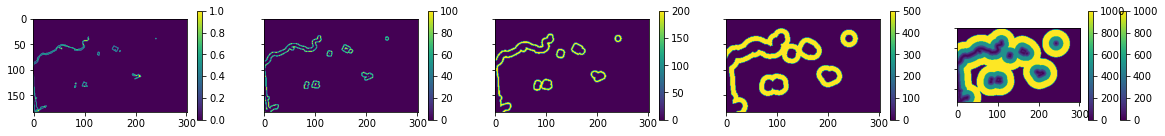

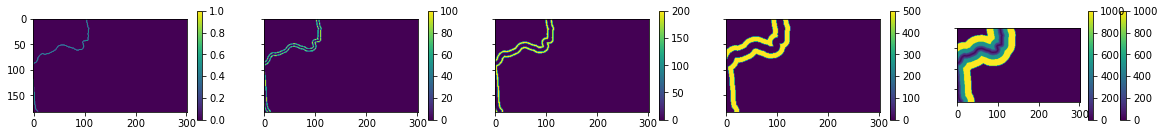

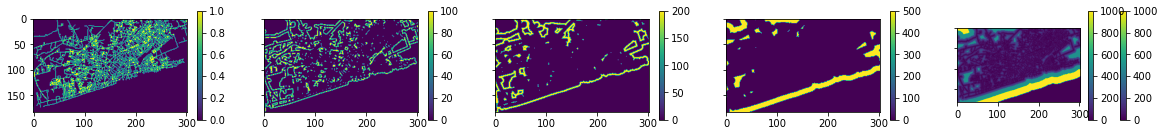

In [31]:
#polygon waterbodies
%time

for name, query in queries.items():
    try:
        buffer_range = [50,100,200,500,1000]
        ogr_f = read_shapefile(f"{INTER}/{REGION}_pro_{name}.shp")
        if ogr_f:
            pro_gpd = gpd.read_file(f"{INTER}/{REGION}_pro_{name}.shp")
            poly_rast = make_buffer(ogr_f, pro_gpd, buffer_range)
            np.save(f"{OUTPUT}/{REGION}_{name}_rast1.npy", poly_rast)
    except Exception as e:
        print(f'Exception occured {e}')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


Warning 1: Failed to fetch spatial reference on layer puri_input_shape_100_50 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_200_100 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_500_200 to build transformer, assuming matching coordinate systems.
Warning 1: Failed to fetch spatial reference on layer puri_input_shape_1000_500 to build transformer, assuming matching coordinate systems.


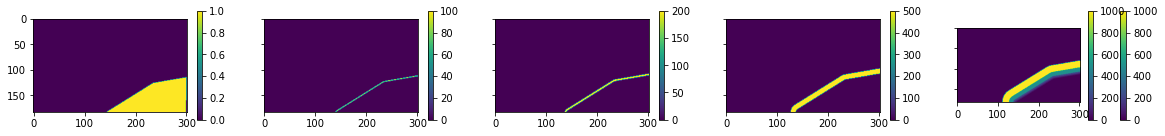

In [32]:
%time
if not ocean.empty:
    buffer_range = [50,100,200,500,1000]
    ocean_ogr = read_shapefile(f"{INTER/REGION}_ocean.shp")

    ocean_gpd = ocean
    ocean_rast = make_buffer(ocean_ogr, ocean_gpd, buffer_range)
    np.save(f"{OUTPUT/REGION}_ocean_rast1.npy", ocean_rast)

In [33]:
#Read Saved .npy for now
try:
    if Path(f"{OUTPUT/REGION}_ocean_rast1.npy").exists():
        ocean_rast = np.load(f"{OUTPUT/REGION}_ocean_rast1.npy")
except Exception as e:
    print(f'Exception occured {e}')

try:
    if Path(f"{OUTPUT/REGION}_roads_rast1.npy").exists():
        roads_rast = np.load(f"{OUTPUT/REGION}_roads_rast1.npy")
except Exception as e:
    print(f'Exception occured {e}')

try:
    if Path(f"{OUTPUT/REGION}_water_poly_rast1.npy").exists():
        water_poly_rast = np.load(f"{OUTPUT/REGION}_water_poly_rast1.npy")
except Exception as e:
    print(f'Exception occured {e}')

try:
    if Path(f"{OUTPUT/REGION}_water_line_rast1.npy").exists():
        water_line_rast = np.load(f"{OUTPUT/REGION}_water_line_rast1.npy")
except Exception as e:
    print(f'Exception occured {e}')

# DEM Processing

In [34]:
base_directory = Path.cwd()
elevation_file_name = f"{INTER}/{REGION}_dem_test.tif"

In [35]:
west, south, east, north = bounds = bbox
west, south, east, north = bounds = west - .1, south - .1, east + .1, north + .1

In [60]:
def getDEMFile(bounds, outputFileName):
    elevation.clip(bounds, output=outputFileName)
    elevation.clean()

In [56]:
el_box=bounds

In [83]:
a = round(el_box[0], 2)
b = round(el_box[1], 2)
c = round(el_box[2], 2)
d = round(el_box[3], 2)

In [84]:
el_box

(85.67901840209962, 19.6802728929679, 85.9650207519531, 19.930178734472012)

In [88]:
!eio clip -o {INTER}/{REGION}_dem_test.tif --bounds 85.67 19.68 85.96 19.93

make: Entering directory '/root/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/root/.cache/elevation/SRTM1'
make: Entering directory '/root/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/root/.cache/elevation/SRTM1'
make: Entering directory '/root/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.1d0163234b7c4068a1e514b03c7a36ec.vrt
make: Leaving directory '/root/.cache/elevation/SRTM1'
make: Entering directory '/root/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 85.67 19.93 85.96 19.68 SRTM1.1d0163234b7c4068a1e514b03c7a36ec.vrt /mnt/d/gramener_dell_data/desktop_data/Sumedh/Seeds/sunnylives/production/nbs/production/puri/modeloutput/riskscore/inter/puri_dem_test.tif
rm -f SRTM1.1d0163234b7c4068a1e514b03c7a36ec.vrt
make: Leaving directory '/root/.cache/elevation/SRTM1'


In [89]:
# getDEMFile(bounds, elevation_file_name)

In [90]:
def get_layer(raster_file):
    ds = gdal.Open(raster_file, gdal.GA_ReadOnly)
    print(ds)
    rb = ds.GetRasterBand(1)
    img_array = rb.ReadAsArray()
    return ds, img_array

In [91]:
band_dem, dem_array = get_layer(f"{INTER/REGION}_dem_test.tif")

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f11aa8e9e70> >


In [92]:
band_dem = (f"{INTER/REGION}_dem_test.tif")
band_dem = rxr.open_rasterio(band_dem,
                              masked=True).squeeze()

band_dem.rio.write_crs("epsg:4326", inplace=True)

band_dem.rio.to_raster(f"{OUTPUT}/{REGION}_dem_4326.tif")

In [93]:
#band_dem.GetProjection()

In [94]:
# Source
src_filename = f"{OUTPUT}/{REGION}_dem_4326.tif"
src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
src_proj = src.GetProjection()
src_geotrans = src.GetGeoTransform()

# We want a section of source that matches this:
match_filename = f"{INTER/REGION}_poly_buffer_0.tif"
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

# Output / destination
dst_filename = f"{INTER/REGION}_prodem.tif"
dst = gdal.GetDriverByName('GTiff').Create(dst_filename, wide, high, 1, 
                                           gdalconst.GDT_Float32)
dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

# Do the work
gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

del dst # Flush

# D8 (O’Callaghan and Mark, 1984)
O’Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323–344.

The D8 method assigns flow from a focal cell to one and only one of its 8 neighbouring cells. The chosen neighbour is the one accessed via the steepest slope. When such a neighbour does not exist, no flow direction is assigned. When two or more neighbours have the same slope, the chosen neighbour is the first one considered by the algorithm.

This is a convergent, deterministic flow method.


A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 30785
p Calculating flow accumulation...
t Wall-time       = 0.0049331 s============== ] (99% - 0.0s - 1 threads)


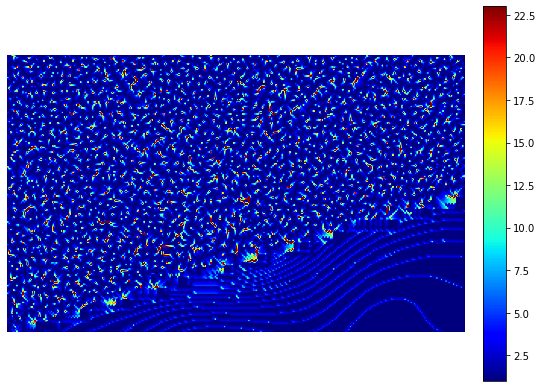

In [95]:
#Get flow accumulation with no explicit weighting. The default will be 1.
prodem=rd.LoadGDAL(f"{INTER/REGION}_prodem.tif", no_data=-9999)
accum_d8 = rd.FlowAccumulation(prodem, method='D8')
d8_fig = rd.rdShow(accum_d8, figsize=(8,5.5), axes=False, cmap='jet')

In [96]:
#Slope Calculation using gdal dem is an apt method
!gdaldem slope {INTER/REGION}_prodem.tif {INTER/REGION}_output_slope_map.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [97]:
assert Path(f'{INTER/REGION}_output_slope_map.tif').exists()

# Process of calculating TWI

In [98]:
slope_deg,slope_degree = get_layer(f"{INTER/REGION}_output_slope_map.tif")
#Later we have to take a natural logarithm (ln) so we avoid zeros in the map 
slope_degree_modified = (slope_degree <=0) * 1 + (slope_degree > 0)*slope_degree
#convert the slope degrees to radiance--> multiply with conversion factor
slope_rad = ( slope_degree_modified * 0.017430 )
twi = np.log((accum_d8+ 1*30)/np.tan(slope_rad))

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f11aa78b720> >


In [99]:
twi

rdarray([[7.48344835, 7.48344835, 7.51519705, ..., 7.51519705,
          7.54596871, 7.48344835],
         [7.51519705, 6.63563221, 6.32494733, ..., 7.10822789,
          6.54661719, 7.48344835],
         [7.48344835, 8.97914217, 6.80412222, ..., 7.3393874 ,
          7.17170198, 7.48344835],
         ...,
         [7.48344835, 6.54061112, 5.25100959, ..., 7.48344835,
          7.48344835, 7.48344835],
         [7.48344835, 5.7927345 , 5.23185524, ..., 7.48344835,
          7.48344835, 7.48344835],
         [7.48344835, 7.48344835, 7.51519705, ..., 7.48344835,
          7.48344835, 7.48344835]])

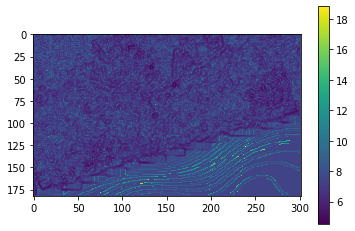

In [100]:
### Higher The TWI higher the risk
plt.imshow(twi, interpolation='none')
plt.colorbar()
plt.show()

[]

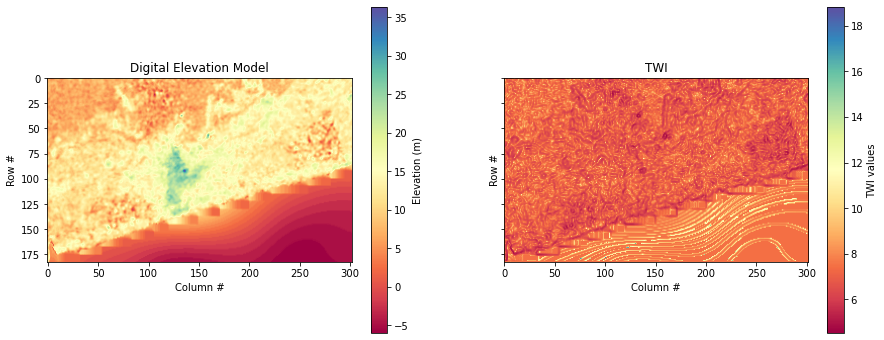

In [101]:
%matplotlib inline
fig, axes = plt.subplots(1,2, figsize=(15,10), sharex=True, sharey=True)
cmap = plt.get_cmap('Spectral')

plt.sca(axes[0])
plt.imshow(prodem, cmap=cmap)
plt.colorbar(shrink=0.6, label='Elevation (m)')
plt.title('Digital Elevation Model')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[1])
plt.imshow(twi, cmap=cmap)
degree_sign= u'\N{DEGREE SIGN}'
plt.colorbar(shrink=0.6, label='TWI values')
plt.title('TWI')
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.plot()

In [102]:
twi.min(), twi.max(), twi.mean()

(rdarray(4.53488824), rdarray(18.83501938), rdarray(7.26499556))

In [103]:
prodem.min(), prodem.max(), prodem.mean()

(rdarray(-6., dtype=float32),
 rdarray(36.396004, dtype=float32),
 rdarray(8.394539, dtype=float32))

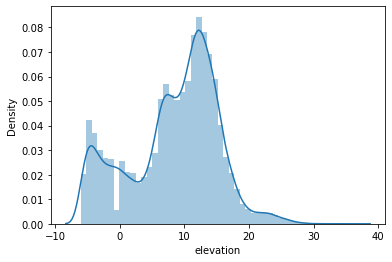

In [104]:
ax = sns.distplot(prodem.ravel(), axlabel='elevation')
ax = plt.gca()

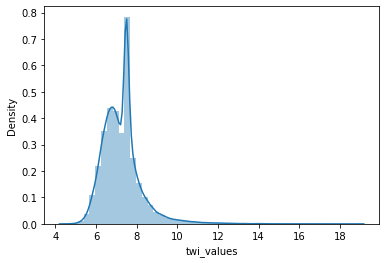

In [105]:
ax = sns.distplot(twi.ravel(), axlabel='twi_values')
ax = plt.gca()

In [106]:
region= rio.open(f"{INTER/REGION}_output_slope_map.tif")
with rio.Env():
    profile = region.profile.copy()
    profile.update({'dtype': 'float64', 'count': 1})
    
    with rio.open(f"{INTER/REGION}_twi.tif", 'w', **profile) as f:
        f.write(twi, 1)

#  Landuse

In [107]:
#Read band as array
def read_data_asarray(band_path):
    band = gdal.Open(band_path)
    return band, band.ReadAsArray().astype(np.float)

In [108]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [109]:
r = list_files(RAW)

In [110]:
#/test/heat/data/input/delhi/LC.tif|txt
for idx, path in enumerate(r):
    path = path.replace(' ', '')
    path1 = path.split('/')[-1]

In [111]:
#%%time
path_list = []
year_month1_list = []
year_month2_list = []
product_list = []
metayear_month_list = []
for idx, path in enumerate(r):
    path = path.replace(' ', '')
    try:
        ext = path.split('.')[-1].lower()
        if ext == 'tif':
            path1 = path.split('/')[-1]
            a = str(path1)
            path_list.append(a)
            year_month1 = a.split('_')[3]
            year_month1_list.append(year_month1)
            year_month2 = a.split('_')[4]
            year_month2_list.append(year_month2) 
            product = a.split('_')[2]
            product_list.append(product) 
            
        elif ext =='txt':
            path2 = path.split('/')[-1]
            b = str(path2)
            metadata_list = b
            metayear_month_list.append(metadata_list)
    except Exception as e:
        print(f'Exception occured {e}')

Exception occured list index out of range
Exception occured list index out of range
Exception occured list index out of range
Exception occured list index out of range


In [112]:
prod_list = list(set(product_list))
for m, n in enumerate (prod_list):
    print(n)

139046


In [113]:
date_list = list(set(year_month1_list))
for i, j in enumerate (date_list):
    print(j)

20210315


In [114]:
landsat_paths = [str(path) for path in RAW.glob('*') if 'LC08' in str(path)]

In [115]:
assert len(landsat_paths) != 0

In [116]:
from rasterio.mask import mask
def clip(src, like):
    with rio.open(src, 'r') as idata:
        with rio.open(like, 'r') as lf:
            bounds = lf.bounds
            minx, miny, maxx, maxy = bounds[0], bounds[1], bounds[2], bounds[3]
                        
            assert idata != None
            bbox = box(minx, miny, maxx, maxy)
            coords_gdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=UTM)
            
            #coords_gdf = coords_gdf.to_crs(crs=idata.crs)
            coords =  [json.loads(coords_gdf.to_json())['features'][0]['geometry']]

            out_img, out_transform = mask(idata, all_touched=True, shapes=coords, crop=True)
            print(out_img.shape)
            out_meta = idata.meta.copy()
            out_meta.update({"driver": "GTiff",
                             "height": out_img.shape[1],
                             "width": out_img.shape[2],
                             "transform": out_transform,
                             "crs": idata.crs}
                            )
            return out_img, out_transform, out_meta

In [117]:
for lp in tqdm(landsat_paths):
    imageid = lp.split('/')[-1]
    productid = imageid.split('_')[2]
    date1 = imageid.split('_')[3]
    date2 = imageid.split('_')[4]
    bandno = imageid.split('.')[0].split('_')[-1].lower()
    os.makedirs(CROPPED, exist_ok=True)
    ext = imageid.split('.')[-1].lower()
    op = f'{CROPPED/date1}_{REGION}_cropped_{bandno}.tif'
    if ext == 'tif' and not Path(op).exists():
        !echo {op} >> {CROPPED}/logs.txt
        out_img, out_transform, out_meta = clip(lp, f'{INTER}/{REGION}_output_slope_map.tif')
        with rio.open(op, "w", **out_meta) as dest:
            dest.write(out_img)
            
        assert Path(op).exists()

 11%|█████████▍                                                                           | 1/9 [00:00<00:06,  1.28it/s]

(1, 184, 303)


 22%|██████████████████▉                                                                  | 2/9 [00:01<00:05,  1.32it/s]

(1, 184, 303)


 33%|████████████████████████████▎                                                        | 3/9 [00:02<00:04,  1.33it/s]

(1, 184, 303)


 44%|█████████████████████████████████████▊                                               | 4/9 [00:02<00:03,  1.35it/s]

(1, 184, 303)
(1, 184, 303)


 67%|████████████████████████████████████████████████████████▋                            | 6/9 [00:04<00:02,  1.32it/s]

(1, 184, 303)
(1, 184, 303)


100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.46it/s]

(1, 184, 303)


In [118]:
date_list = list(set(year_month1_list))
date_list2 = list(set(year_month2_list))
prod_list =  list(set(product_list))

In [119]:
# Import User Config file to set globals
config_file = GLOBAL/'config.yaml'
user_config = yaml.load(open(config_file), Loader=yaml.FullLoader)

# Globals
brightness_bands = user_config['UHI']['bands'].get('brightness', [])
reflectance_bands = user_config['UHI']['bands'].get('reflectance', [])
radiance_bands=user_config['UHI']['bands'].get('radiance', [])
allbands = brightness_bands+reflectance_bands
crs = UTM

In [120]:
def get_metaData_dict(text_file_path):
    text_file = open(text_file_path, "r").read() #change
    
    meta_data_dict={}
    for num, line in enumerate(text_file.strip().split("\n")):
        if num==(len(text_file.strip().split("\n"))-1):
            continue
        split_line =  line.strip().split(' = ')
        meta_data_dict[split_line[0]] = split_line[1]
    return meta_data_dict

#Globals 
for i, k in enumerate (metayear_month_list):
    ls_txt = f"{RAW}/{k}"
    metadata= get_metaData_dict(ls_txt)


for i, j in enumerate (date_list):
    
    def read_data_asarray(input_tiff_path):
        gtif = gdal.Open(input_tiff_path)
        band = gtif.GetRasterBand(1)
        bandArray = band.ReadAsArray()
        return band, bandArray


    def show_map(maparray):
        %matplotlib inline
        plt.figure(figsize=(10,10))
        plt.imshow(maparray, cmap="RdYlGn")
        plt.colorbar()


    def extract_brightness(band, tiff_data):
        res = {}
        TOA_spectral_radiance = (float(
            metadata[f'RADIANCE_MULT_BAND_{band}']
            ) * tiff_data[1]) + float(metadata[f'RADIANCE_ADD_BAND_{band}'])
        
        ta_brightness1=float(metadata[f'K2_CONSTANT_BAND_{band}'])
        ta_brightness2= np.log(float(metadata[f'K1_CONSTANT_BAND_{band}']) / TOA_spectral_radiance) 
        top_atmos_brightness=(ta_brightness1/ta_brightness2+1)
        
        res[band] = top_atmos_brightness
        return res


    def extract_reflectance(band, tiff_data):
        res = {}
        sun_elevation_meta = metadata['SUN_ELEVATION']

        TOA_planetary_reflectance_no = (float(
            metadata[f'REFLECTANCE_MULT_BAND_{band}']
        ) * tiff_data[1]) + float(metadata[f'REFLECTANCE_ADD_BAND_{band}'])

        theta_se = math.pi / 180 * float(sun_elevation_meta)
        # theta_sz = 90 - theta_se
    
        TOA_planetary_reflectance = TOA_planetary_reflectance_no / (math.sin(theta_se))
        # TOA_planetary_reflectance = TOA_planetary_reflectance_no / (np.cos(theta_sz))

        res[band] = TOA_planetary_reflectance
        return res

    brightness = {}
    reflectance = {}
    def calculate_brightness():
        for band in brightness_bands:
            tdata = read_data_asarray(f"{CROPPED}/{j}_{REGION}_cropped_b{band}.tif")
            brightness.update(extract_brightness(band, tdata))


    def calculate_reflectance():
        for band in reflectance_bands:
            tdata = read_data_asarray(f"{CROPPED}/{j}_{REGION}_cropped_b{band}.tif")
            reflectance.update(extract_reflectance(band, tdata))


    calculate_brightness()
    calculate_reflectance()
    # Calculate LST
    def calculate_NDVI(reflectance):
        check_4 = np.logical_and(reflectance[5] > 0, reflectance[4] > 0 ) ### Checking for nan/filler values in mir and nir
        NDVI = np.where(check_4, ((reflectance[5] - reflectance[4] ) / ( reflectance[5] + reflectance[4] )), -1)
        return NDVI
    
    def calculate_NDMI(reflectance):
        check_4 = np.logical_and(reflectance[5] > 0, reflectance[6] > 0 ) ### Checking for nan/filler values in mir and nir
        NDMI = np.where(check_4, ((reflectance[5] - reflectance[6] ) / ( reflectance[5] + reflectance[6] )), -1)
        return NDMI


    def calculate_NDBI(reflectance):
        check_6 = np.logical_and(reflectance[5] > 0, reflectance[6] > 0)
        NDBI = np.where(check_6, ((reflectance[5] - reflectance[6] ) / ( reflectance[5] + reflectance[6] )), -1)
        return NDBI


    def calculate_vegetation(reflectance):
        ndvi_array = calculate_NDVI(reflectance)
        #NDBI = calculate_NDBI(reflectance)
        vegetation_proportion = ((ndvi_array - ndvi_array.min())/(ndvi_array.max()-ndvi_array.min())**2)
        return vegetation_proportion

    def calculate_MNDWI(reflectance):
        check_6 = np.logical_and(reflectance[3] > 0, reflectance[6] > 0)
        MNDWI = np.where(check_6, ((reflectance[3] - reflectance[6] ) / ( reflectance[3] + reflectance[6] )), -1)
        return MNDWI

    def calculate_ALBEDO(reflectance):
        check_6 = np.logical_and(reflectance[3] > 0, reflectance[6] > 0)
        ALBEDO = np.where(check_6, (((0.356 * reflectance[2]) + (0.15 * reflectance[4]) + (0.373 * reflectance[5])
                                     + (0.085 * reflectance[6]) + (0.072 * reflectance[7]) - 0.0018)/ 1.016) , -1)
        return ALBEDO

    def calculate_emissivity(reflectance):
        vegetation_proportion = calculate_vegetation(reflectance)
        emissivity = 0.004 * vegetation_proportion + 0.986
        return emissivity


    def calculate_LST(brightness, reflectance):
        ndvi_array=calculate_NDVI(reflectance)
        check_7 = np.logical_and(brightness[10] > 0, brightness[11] > 0)
        
        pv= ((ndvi_array - ndvi_array.min())/(ndvi_array.max()-ndvi_array.min())**2)
        #print(pv)
        #land surface emissivity
        em = 0.004 * pv + 0.986

        lst_10 = np.where(check_7, ((brightness[10] / (1 + (0.00115 * brightness[10] / 1.4388) * np.log(em))) -273.15), -1)
        #print(lst_10)      
        lst_11 = np.where(check_7, ((brightness[11] / (1 + (0.00115 * brightness[11] / 1.4388) * np.log(em))) -273.15), -1)
        lst_avg = (np.array(lst_10) + np.array(lst_11)) / 2
        print(lst_avg)
        return lst_avg
    ###################################
    path_list=[]
    subfolder_list=[]
    data_list=[]

    #Globals 
    with rio.Env():
        region = rasterio.open(f"{CROPPED}/{j}_{REGION}_cropped_b4.tif")
        profile = region.profile.copy()
        profile.update({'dtype': 'float32', 'count': 1})

        #LST
        lst_avg = calculate_LST(brightness, reflectance)
        lst_avg = lst_avg.astype('float32') 
        with rio.open(f'{OUTPUT}/{j}_{REGION}_lst.tif', 'w', **profile) as f:
                f.write(lst_avg, 1)

        #NDVI
        ndvi = calculate_NDVI(reflectance)
        ndvi = ndvi.astype('float32') 
        with rio.open(f'{OUTPUT}/{j}_{REGION}_ndvi.tif', 'w', **profile) as f:
                f.write(ndvi, 1)
        #NDMI
        ndmi = calculate_NDMI(reflectance)
        ndmi = ndmi.astype('float32') 
        with rio.open(f'{OUTPUT}/{j}_{REGION}_ndmi.tif', 'w', **profile) as f:
                f.write(ndmi, 1)
        #NDBI
        ndbi = calculate_NDBI(reflectance)
        ndbi = ndbi.astype('float32') 
        with rio.open(f'{OUTPUT}/{j}_{REGION}_ndbi.tif', 'w', **profile) as f:
                f.write(ndbi, 1)

        #MNDWI
        mndwi = calculate_MNDWI(reflectance)
        mndwi = mndwi.astype('float32') 
        with rio.open(f'{OUTPUT}/{j}_{REGION}_mndwi.tif', 'w', **profile) as f:
                f.write(mndwi, 1)

        #ALBEDO
        albedo = calculate_ALBEDO(reflectance)
        albedo = albedo.astype('float32') 
        with rio.open(f'{OUTPUT}/{j}_{REGION}_albedo.tif', 'w', **profile) as f:
                f.write(albedo, 1)

[[33.79122218 33.85582713 33.88880155 ... 32.82967155 32.91756962
  32.99748985]
 [33.70967968 33.76358574 33.78053648 ... 32.78077869 32.92140674
  33.02928993]
 [33.60198036 33.65497948 33.66507081 ... 32.72011928 32.93263697
  33.09435865]
 ...
 [35.39099264 34.96441329 34.4017942  ... 26.80020541 26.7941141
  26.80514163]
 [35.17354713 34.87856772 34.50044051 ... 26.78291772 26.77637755
  26.78855909]
 [34.83925676 34.41496573 33.98413429 ... 26.79670728 26.78924925
  26.79113934]]


In [121]:
#### open all LST files in summer and take an average
OPDATA = Path(f'{OUTPUT}/')

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

r = list_files(OPDATA)

In [122]:
#%%time
path_list=[]
lst_list=[]
#year_month2_list=[]
product_list=[]
metayear_month_list=[]
for idx, path in enumerate(r):
    #print(path)
    try:
        if 'lst.tif' in path:
            path1 = path.split('/')[-1]
            a = str(path1)
            path_list.append(a)
            lst_file = a
            lst_list.append(lst_file)
            product = a.split('_')[0]
            product_list.append(product) 

    except Exception as e:
        print(f'Exception occured {e}')

In [123]:
lst_list = list(set(lst_list))
product = list(set(product_list))

sum_array=0

print(lst_file)
iterator = 1
for i, j in enumerate (lst_list):
    band, band_array = read_data_asarray(f'{OUTPUT}/{j}')
    sum_array= band_array+sum_array
    iterator= i + 1 
    
sum_array /= iterator

20210315_puri_lst.tif


In [124]:
sum_array

array([[33.79122 , 33.855827, 33.8888  , ..., 32.82967 , 32.91757 ,
        32.99749 ],
       [33.70968 , 33.763584, 33.780537, ..., 32.780777, 32.921406,
        33.02929 ],
       [33.601982, 33.65498 , 33.66507 , ..., 32.72012 , 32.932636,
        33.09436 ],
       ...,
       [35.39099 , 34.964413, 34.401794, ..., 26.800205, 26.794113,
        26.805141],
       [35.173546, 34.878567, 34.50044 , ..., 26.782917, 26.776377,
        26.788559],
       [34.839256, 34.414967, 33.984135, ..., 26.796707, 26.78925 ,
        26.79114 ]], dtype=float32)

In [125]:
for i, j in enumerate (date_list):
    with rio.Env():
        region = rasterio.open(f"{CROPPED}/{j}_{REGION}_cropped_b4.tif")
        profile = region.profile.copy()
        profile.update({'dtype': 'float32', 'count': 1})

    with rio.open(f'{OUTPUT}/{REGION}_LST_AVG.tif', 'w', **profile) as f:
        f.write(sum_array, 1)

# Closest date to the current date

In [126]:
def identify_closest_date(date_list):
    now = datetime.date.today()

    date_list_converted = [datetime.datetime.strptime(each_date, "%Y%m%d").date() for each_date in date_list]
    differences = [abs(now - each_date) for each_date in date_list_converted]
    minimum = min(differences)
    closest_date = date_list[differences.index(minimum)]
    return closest_date

In [127]:
closest_date=identify_closest_date(date_list)

# Read required files 

In [128]:
ndvi, ndvi_array = read_data_asarray(f'{OUTPUT}/{closest_date}_{REGION}_ndvi.tif')
ndmi, ndmi_array = read_data_asarray(f'{OUTPUT}/{closest_date}_{REGION}_ndmi.tif')
ndbi, ndbi_array = read_data_asarray(f'{OUTPUT}/{closest_date}_{REGION}_ndbi.tif')
#lst, lst_array = read_data_asarray(f'{OUTPUT}/{REGION}_LST_AVG.tif')

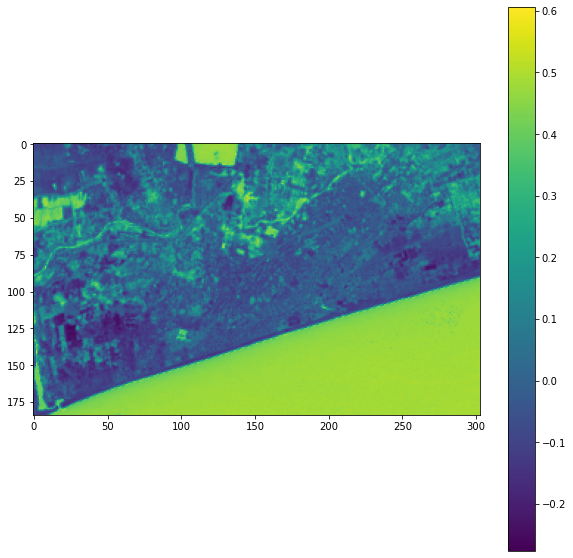

In [129]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(ndbi_array)   #put any array name to visualize
plt.colorbar()

In [130]:
# classify NDVI
def create_levels_of_vegetation(fi):
    cor_fi = np.zeros_like(fi, dtype=np.float32)# -0.019999
    cor_fi[np.where(fi > 0.5)]  = 2    #Dense
    cor_fi[np.where((fi > 0.2) & (fi < 0.5))] = 1 #sparse
    cor_fi[np.where(fi < 0.2)] = 0 #No vegetation
    return cor_fi

def create_levels_of_moisture(fi):
    cor_fi = np.zeros_like(fi, dtype=np.float32)# -0.019999
    cor_fi[np.where(fi > 0.4)]  = 2    #Dense
    cor_fi[np.where((fi > -0.2) & (fi < 0.4))] = 1 #sparse
    cor_fi[np.where(fi < -0.2)] = 0 #No vegetation
    return cor_fi

# Do the same with NDBI
def create_levels_of_builtup(fi):
    cor_fi = np.zeros_like(fi, dtype=np.float32)# -0.019999
    cor_fi[np.where((fi > 0.0) & (fi < 0.12))] = 1    ## 0.06...,   0.041143
    cor_fi[np.where((fi <0) & (fi >  0.12))] = 0 
    return cor_fi


def create_levels_of_impervious(fi):
    #fi= cor_ndbi - cor_ndvi
    cor_impervious = np.zeros_like(fi, dtype=np.float32)# -0.019999
    cor_impervious[np.where(fi > 0)]  = 1    #impervious
    cor_impervious[np.where(fi < 0)]  = 0  #pervious
    return cor_impervious



In [131]:
cor_ndvi = create_levels_of_vegetation(ndvi_array)
cor_ndmi = create_levels_of_moisture(ndmi_array)
cor_ndbi = create_levels_of_builtup(ndbi_array)


In [132]:
fi=cor_ndbi - cor_ndvi

cor_impervious=create_levels_of_impervious(fi)

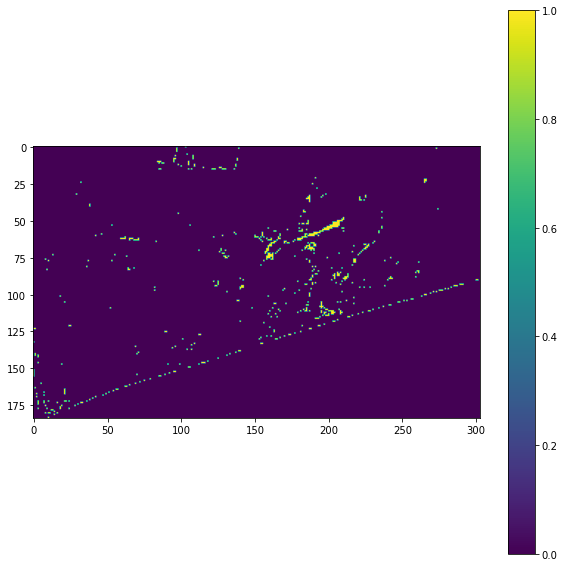

In [133]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(cor_impervious)   #put any array name to visualize
plt.colorbar()

In [134]:
with rio.open(f'{OUTPUT}/{REGION}_impervious_try.tif', 'w', **profile) as f:
        f.write(cor_impervious, 1)

# Landslide Risk
Very High: 
Slope greater than 70% AND (Vegetation cover less than 75% with No visible retaining wall)

High:
Slope greater than 70% AND  (Vegetation cover 75% or more OR visible retaining wall)
Slope between 30 and 70% AND (Vegetation cover less than 75% with No visible retaining wall)

Medium:
Slope between 30 and 70% AND  (Vegetation cover 75% or more OR visible retaining wall)

Low:
Slope below 30%

In [135]:
!gdaldem slope {INTER}/{REGION}_prodem.tif {INTER/REGION}_output_slope_map_perc.tif -of GTiff -b 1 -s 1.0 -p

0...10...20...30...40...50...60...70...80...90...100 - done.


In [136]:
slope_p,slope_perc = get_layer(f"{INTER}/{REGION}_output_slope_map_perc.tif")

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f11ab2a3b10> >


In [137]:
slope_perc= (slope_perc >=0) * 1 + (slope_perc > 0)*slope_perc


In [138]:
def create_levels_of_elevation(fi):
    cor_fi = np.zeros_like(fi, dtype=np.float32)# -0.019999
    cor_fi[np.where(fi > 70)]  = 2    #Dense
    cor_fi[np.where((fi > 30) & (fi < 70))] = 1 #sparse
    cor_fi[np.where(fi < 30)] = 0 #No vegetation
    return cor_fi

def calculate_landslide(cor_ndvi, cor_slope):
    weight_landslide = {'ndvi': 30, 
                        'slope':70} 
    weighed_sum_landslide = (cor_ndvi*weight_landslide['ndvi']+
                            cor_slope*weight_landslide['slope'])/100
    
    return weighed_sum_landslide

In [139]:
cor_slope=create_levels_of_elevation(slope_perc)
cor_ndvi = cor_ndvi[1:, :cor_slope.shape[1]]

landslide_risk= calculate_landslide(cor_ndvi, cor_slope)

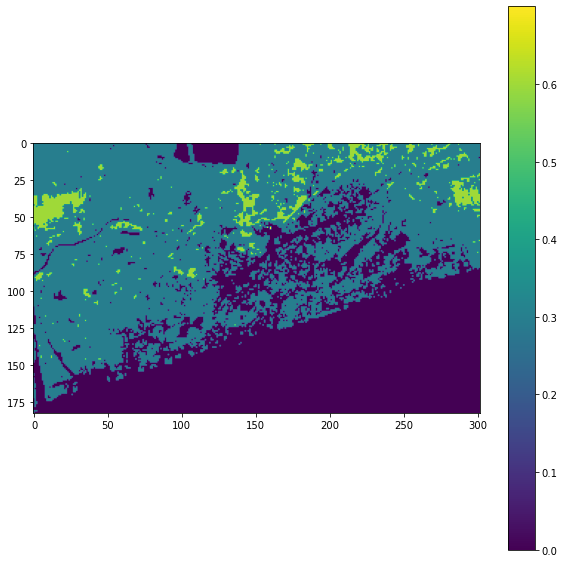

In [140]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(landslide_risk)
plt.colorbar()

In [141]:
#function convert array to raster

def arr_raster(dataset, output_path, epsg_code): # dataset: array to be converted to raster
    utm_conversion = utm.from_latlon(bbox[3],bbox[0])
    xmin = utm_conversion[0]
    ymax = utm_conversion[1]
    geo_transform = (xmin, 5.0, 0.0, ymax, 0.0, -5.0)
    arr_out = dataset
    [cols2, rows2] = arr_out.shape
    epsg = epsg_code
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    projection = srs.ExportToWkt()
    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(output_path, rows2, cols2, 1, gdal.GDT_Float32)
    outdata.SetGeoTransform(geo_transform)##sets same geotransform as input
    outdata.SetProjection(projection)##sets same projection as input
    outdata.GetRasterBand(1).WriteArray(arr_out)
    outdata.GetRasterBand(1).SetNoDataValue(9999)##if you want these values transparent
    outdata.FlushCache() ##saves to disk!!
    outdata = None
    band = None
    ds = None 

# Dataset from Footprints Model

In [142]:
%%html
<style>
table {float:left}
</style>

In [143]:
area = ["ATTRIBUTE=area"]
label = ["ATTRIBUTE=label"]
id_tag= ["ATTRIBUTE=id"]
def create_raster_from_footprints( xRes, yRes, format, nodata, rasterFile, bbox_, shplayer, options):

    box = list(bbox_)
    UTM_grid=pyproj.Proj(init= 'epsg'+':'+ str(UTM))
    wgs84=pyproj.Proj(init= 'epsg'+':'+ str(WGS84))
    lon = []
    lat = []
    lon.append(box[0])
    lon.append(box[2])
    lat.append(box[1])
    lat.append(box[3])
    xx, yy = pyproj.transform(wgs84, UTM_grid, lon, lat)
    shp_extent = [xx[0], xx[1],yy[0], yy[1]]
    
    tiff_width = int(np.ceil(abs(shp_extent[1] - shp_extent[0]) / xRes))
    tiff_height = int(np.ceil(abs(shp_extent[3] - shp_extent[2]) / yRes))

    if rasterFile is not None:
        driver = gdal.GetDriverByName('GTiff')
    else:
        rasterFile = ''
        driver = gdal.GetDriverByName('MEM')

        # 1 means only create 1 band
    raster = driver.Create(
        rasterFile, tiff_width, tiff_height, 1, format,
        options=['BIGTIFF=IF_SAFER'])

    raster.GetRasterBand(1).SetNoDataValue(nodata)
    raster_transform = [shp_extent[0], xRes, 0.0, shp_extent[3], 0.0, -yRes]
    raster.SetGeoTransform(raster_transform)
        # Use the same projection on the raster as the shapefile
    srs = osr.SpatialReference()
    srs.ImportFromWkt(shplayer.GetLayer(0).GetSpatialRef().__str__())
    raster.SetProjection(srs.ExportToWkt())
    raster.GetRasterBand(1).Fill(nodata)

    # gdal.RasterizeLayer(raster, [1], shp.GetLayer(), burn_values=[1])# to fill point value as burn with one
    gdal.RasterizeLayer(raster, [1], shplayer.GetLayer(), options = options )
    raster.GetRasterBand(1).FlushCache()


In [144]:
def get_city_footprints(region_box):
    city_footprints_4326 = gpd.read_file(f"{FOOTPRINTS}/{REGION}_footprints.geojson")
    buffer = city_footprints_4326.buffer(0.00000001)
    city_footprints_4326 = city_footprints_4326.drop(columns='geometry')
    city_footprints_4326['geometry'] = buffer
    city_footprints_4326 = gpd.clip(city_footprints_4326, region_box)
    city_footprints = city_footprints_4326.to_crs(epsg=UTM)
    city_footprints['area'] = city_footprints.area
    try:
        with open(f"{RAW}/{REGION}_footprints_32644.shp") as file:
            city_footprints_shape = read_shapefile(f"{RAW}/{REGION}_footprints_4326.shp")
    except :
        city_footprints_4326.to_file(f"{INTER}/{REGION}_footprints_4326.shp")
        city_footprints=city_footprints_4326.to_crs(UTM)
        city_footprints['area']= city_footprints.area
        city_footprints.to_file(f"{INTER}/{REGION}_footprints_{UTM}.shp")
        city_footprints.to_file(f"{INTER}/{REGION}_footprints_{UTM}.geojson", driver='GeoJSON')
        city_footprints_shape = read_shapefile(f"{INTER}/{REGION}_footprints_{UTM}.shp")
        
    return city_footprints_shape

In [145]:
city_footprints_shape= get_city_footprints(region_boundary)

In [146]:
city_footprints_shape

<osgeo.ogr.DataSource; proxy of <Swig Object of type 'OGRDataSourceShadow *' at 0x7f11a98d9b10> >

In [147]:
create_raster_from_footprints( xRes= 5, yRes= 5, format = gdal.GDT_UInt32, 
                                nodata= 0, rasterFile = f"{INTER}/{REGION}_area.tif", 
                                bbox_=bbox, shplayer = city_footprints_shape, options=area )

create_raster_from_footprints( xRes= 5, yRes= 5, format = gdal.GDT_UInt32, 
                              nodata= 0, 
                              rasterFile = f"{INTER}/{REGION}_label.tif", 
                              bbox_=bbox, shplayer = city_footprints_shape, options=label )

In [148]:
footprints_label, footprints_label_rast = read_data_asarray(f"{INTER}/{REGION}_label.tif")
footprints_area, footprints_area_rast = read_data_asarray(f"{INTER}/{REGION}_area.tif")

In [149]:
with rio.Env():
    region = rasterio.open(f"{CROPPED}/{j}_{REGION}_cropped_b4.tif")
    profile = region.profile.copy()
    profile.update({'dtype': 'uint32', 'count': 1})

try:
    with rio.open(f'{OUTPUT}/{REGION}_water_line_rast.tif', 'w', **profile) as f:
        f.write(water_line_rast, 1)
except:
    pass

try:
    with rio.open(f'{OUTPUT}/{REGION}_water_poly_rast.tif', 'w', **profile) as f:
        f.write(water_poly_rast, 1)
except:
    pass
    
try:
    with rio.open(f'{OUTPUT}/{REGION}_roads_rast.tif', 'w', **profile) as f:
        f.write(roads_rast, 1)
except:
    pass

try:
    with rio.open(f'{OUTPUT}/{REGION}_ocean_rast.tif', 'w', **profile) as f:
        f.write(ocean_rast, 1)
except:
    pass


#read_layers
water_poly, water_poly_rast = read_data_asarray(f'{OUTPUT}/{REGION}_water_poly_rast.tif')
water_line, water_line_rast = read_data_asarray(f'{OUTPUT}/{REGION}_water_line_rast.tif')
roads, roads_rast = read_data_asarray(f'{OUTPUT}/{REGION}_roads_rast.tif')
ocean_data, ocean_rast = read_data_asarray(f'{OUTPUT}/{REGION}_ocean_rast.tif')

In [150]:
## TWI change
rec_list = []

rec_water_poly = np.zeros_like(water_poly_rast, dtype=np.float64)
rec_water_poly[np.where(water_poly_rast >= 300)] = 1
rec_water_poly[np.where((water_poly_rast < 300) & (water_poly_rast >= 200))] = 2
rec_water_poly[np.where((water_poly_rast < 200) & (water_poly_rast >= 125))] = 3
rec_water_poly[np.where((water_poly_rast < 125) & (water_poly_rast >= 75))] = 4
rec_water_poly[np.where(water_poly_rast <= 75)] = 5
rec_list.append(rec_water_poly)
np.save(f"{OUTPUT/REGION}_rec_water_poly.npy", rec_water_poly)

rec_water_line = np.zeros_like(water_line_rast, dtype=np.float64)
rec_water_line[np.where(water_line_rast >= 1300)] = 1
rec_water_line[np.where((water_line_rast < 1300) & (water_line_rast >= 1000))] = 2
rec_water_line[np.where((water_line_rast < 1000) & (water_line_rast >= 500))] = 3
rec_water_line[np.where((water_line_rast < 500) & (water_line_rast >= 200))] = 4
rec_water_line[np.where(water_line_rast < 200)] = 5
rec_list.append(rec_water_line)
np.save(f"{OUTPUT/REGION}_rec_water_line.npy", rec_water_line)

rec_roads = np.zeros_like(roads_rast, dtype=np.float64)
rec_roads[np.where(roads_rast >= 300)] = 1
rec_roads[np.where((roads_rast < 300) & (roads_rast >= 200))] = 2
rec_roads[np.where((roads_rast <200) & (roads_rast >= 100))] = 3
rec_roads[np.where((roads_rast < 100) & (roads_rast >= 50))] = 4
rec_roads[np.where(roads_rast < 50)] = 5
rec_list.append(rec_roads)
np.save(f"{OUTPUT/REGION}_rec_roads.npy", rec_roads)

rec_twi = np.zeros_like(twi, dtype=np.float64)

rec_twi[np.where(twi >twi.mean()+3)] = 5
rec_twi[np.where((twi < twi.mean()+3) & (twi >= twi.mean()+2))] = 4
rec_twi[np.where((twi < twi.mean()+2) & (twi >= twi.mean()))] = 3
rec_twi[np.where((twi < twi.mean()) & (twi >= twi.min()))] = 2
rec_twi[np.where(twi <= twi.min())] = 1                                    #primarily it was 12
rec_list.append(rec_twi)
np.save(f"{OUTPUT/REGION}_rec_twi.npy", rec_twi)

rec_elevation = np.zeros_like(prodem, dtype=np.float64)
rec_elevation[np.where(prodem >= 200)] = 1
rec_elevation[np.where((prodem < 200) & (prodem >= 100))] = 2
rec_elevation[np.where((prodem < 100) & (prodem >= 80))] = 3
rec_elevation[np.where((prodem < 80) & (prodem >= 50))] = 4
rec_elevation[np.where(prodem < 50)] = 5
rec_list.append(rec_elevation)
np.save(f"{OUTPUT/REGION}_rec_elevation.npy", rec_elevation)

rec_ndvi = np.zeros_like(cor_ndvi, dtype=np.float64)
rec_ndvi[np.where(cor_ndvi ==2)] = 1
rec_ndvi[np.where((cor_ndvi > 0) & (cor_ndvi <=1))] = 3
rec_ndvi[np.where(cor_ndvi == 0)] = 5
rec_list.append(rec_ndvi)
np.save(f"{OUTPUT/REGION}_rec_ndvi.npy", rec_ndvi)

rec_impervious = np.zeros_like(cor_impervious, dtype=np.float64)
rec_impervious = np.zeros_like(cor_impervious, dtype=np.float64)
rec_impervious[np.where(cor_impervious >0)] = 4
rec_impervious[np.where(cor_impervious <= 0)] = 2
rec_list.append(rec_impervious)
np.save(f"{OUTPUT/REGION}_rec_impervious.npy", rec_impervious)

rec_landslide = np.zeros_like(landslide_risk, dtype=np.float64)
rec_landslide[np.where(landslide_risk >= landslide_risk.mean()+1.5)] = 5
rec_landslide[np.where((landslide_risk < landslide_risk.mean()+1.5) & (landslide_risk >= landslide_risk.mean()+1))] = 4
rec_landslide[np.where((landslide_risk < landslide_risk.mean()+1) & (landslide_risk > landslide_risk.mean()))] = 3
rec_landslide[np.where((landslide_risk <= landslide_risk.mean()) & (landslide_risk >= landslide_risk.min()))] = 2
rec_landslide[np.where(landslide_risk <= landslide_risk.min())] = 1
rec_list.append(rec_landslide)
np.save(f"{OUTPUT/REGION}_rec_landslide.npy", rec_impervious)

if not ocean.empty:
    rec_ocean = np.zeros_like(ocean_rast, dtype=np.float64)
    rec_ocean[np.where(ocean_rast >=500)] = 1
    rec_ocean[np.where((ocean_rast <300) & (ocean_rast >= 300))] = 2
    rec_ocean[np.where((ocean_rast < 300) & (ocean_rast >= 100))] = 3
    rec_ocean[np.where((ocean_rast < 100) & (ocean_rast >= 50))] = 4
    rec_ocean[np.where(ocean_rast < 50)] = 4
    rec_list.append(rec_ocean)
    np.save(f"{OUTPUT/REGION}_rec_ocean.npy", rec_ocean)
else:
    pass

In [151]:
if not ocean.empty:
    
    crop_widths = [rec_water_poly.shape[0], rec_water_line.shape[0], rec_roads.shape[0]]
    crop_widths += [rec_ndvi.shape[0], rec_landslide.shape[0], rec_twi.shape[0]]
    crop_widths += [rec_elevation.shape[0], rec_impervious.shape[0], rec_ocean.shape[0]]
    min_crop_width = min(crop_widths)
    
    crop_heights = [rec_water_poly.shape[1], rec_water_line.shape[1], rec_roads.shape[1]]
    crop_heights += [rec_ndvi.shape[1], rec_landslide.shape[1], rec_twi.shape[1]]
    crop_heights += [rec_elevation.shape[1], rec_impervious.shape[1], rec_ocean.shape[1]]
    min_crop_height = min(crop_heights)
    
    rec_water_poly = rec_water_poly[rec_water_poly.shape[0] - min_crop_width:, :min_crop_height]
    rec_water_line = rec_water_line[rec_water_line.shape[0] - min_crop_width:, :min_crop_height]
    rec_roads = rec_roads[rec_roads.shape[0] - min_crop_width:, :min_crop_height]
    rec_ndvi = rec_ndvi[rec_roads.shape[0] - min_crop_width:, :min_crop_height]
    rec_landslide = rec_landslide[rec_landslide.shape[0] - min_crop_width:, :min_crop_height]
    rec_twi = rec_twi[rec_twi.shape[0] - min_crop_width:, :min_crop_height]
    rec_elevation = rec_elevation[rec_elevation.shape[0] - min_crop_width:, :min_crop_height]
    rec_impervious = rec_impervious[rec_impervious.shape[0] - min_crop_width:, :min_crop_height]
    rec_ocean = rec_ocean[rec_ocean.shape[0] - min_crop_width:, :min_crop_height]
else:
    crop_widths = [rec_water_poly.shape[0], rec_water_line.shape[0], rec_roads.shape[0]]
    crop_widths += [rec_ndvi.shape[0], rec_landslide.shape[0], rec_twi.shape[0]]
    crop_widths += [rec_elevation.shape[0], rec_impervious.shape[0]]
    min_crop_width = min(crop_widths)
    
    crop_heights = [rec_water_poly.shape[1], rec_water_line.shape[1], rec_roads.shape[1]]
    crop_heights += [rec_ndvi.shape[1], rec_landslide.shape[1], rec_twi.shape[1]]
    crop_heights += [rec_elevation.shape[1], rec_impervious.shape[1]]
    min_crop_height = min(crop_heights)  
    
    rec_water_poly = rec_water_poly[rec_water_poly.shape[0] - min_crop_width:, :min_crop_height]
    rec_water_line = rec_water_line[rec_water_line.shape[0] - min_crop_width:, :min_crop_height]
    rec_roads = rec_roads[rec_roads.shape[0] - min_crop_width:, :min_crop_height]
    rec_ndvi = rec_ndvi[rec_roads.shape[0] - min_crop_width:, :min_crop_height]
    rec_landslide = rec_landslide[rec_landslide.shape[0] - min_crop_width:, :min_crop_height]
    rec_twi = rec_twi[rec_twi.shape[0] - min_crop_width:, :min_crop_height]
    rec_elevation = rec_elevation[rec_elevation.shape[0] - min_crop_width:, :min_crop_height]
    rec_impervious = rec_impervious[rec_impervious.shape[0] - min_crop_width:, :min_crop_height]
                          
    print(rec_water_poly.shape, rec_water_line.shape, rec_roads.shape, rec_ndvi.shape, rec_landslide.shape,rec_twi.shape, rec_elevation.shape, footprints_area_rast.shape)

In [152]:
# crop_widths = [rec_water_poly.shape[0], rec_water_line.shape[0], rec_roads.shape[0]]
# crop_widths += [rec_ndvi.shape[0], rec_landslide.shape[0], rec_twi.shape[0]]
# crop_widths += [rec_elevation.shape[0], rec_impervious.shape[0], rec_ocean.shape[0]]
# min_crop_width = min(crop_widths)

In [153]:
# crop_heights = [rec_water_poly.shape[1], rec_water_line.shape[1], rec_roads.shape[1]]
# crop_heights += [rec_ndvi.shape[1], rec_landslide.shape[1], rec_twi.shape[1]]
# crop_heights += [rec_elevation.shape[1], rec_impervious.shape[1], rec_ocean.shape[1]]
# min_crop_height = min(crop_heights)

In [154]:
# rec_water_poly = rec_water_poly[rec_water_poly.shape[0] - min_crop_width:, :min_crop_height]
# rec_water_line = rec_water_line[rec_water_line.shape[0] - min_crop_width:, :min_crop_height]
# rec_roads = rec_roads[rec_roads.shape[0] - min_crop_width:, :min_crop_height]
# rec_ndvi = rec_ndvi[rec_roads.shape[0] - min_crop_width:, :min_crop_height]
# rec_landslide = rec_landslide[rec_landslide.shape[0] - min_crop_width:, :min_crop_height]
# rec_twi = rec_twi[rec_twi.shape[0] - min_crop_width:, :min_crop_height]
# rec_elevation = rec_elevation[rec_elevation.shape[0] - min_crop_width:, :min_crop_height]
# rec_impervious = rec_impervious[rec_impervious.shape[0] - min_crop_width:, :min_crop_height]
# rec_ocean = rec_ocean[rec_ocean.shape[0] - min_crop_width:, :min_crop_height]

In [155]:
#above modified
if not ocean.empty:
    weight_dict_risk = {'rec_water_poly': 6.2, 
                     'rec_water_line': 19.2,
                     'rec_ocean': 1.5,
                     'rec_roads': 4.5,  
                     'rec_twi': 20.6,  
                     'rec_elevation':4.6,
                     'rec_ndvi': 3.3  ,
                     'landslide_risk':2,
                     'rec_impervious': 2.8,
                     'rec_footprints_label': 21.9,
                     'rec_footprints_area':13.4 } 
else:
    weight_dict_risk = {'rec_water_poly': 6.95, 
                     'rec_water_line': 19.95,
                     'rec_roads': 4.5,  
                     'rec_twi': 20.6,  
                     'rec_elevation':4.6,
                     'rec_ndvi': 3.3  ,
                     'landslide_risk':2,
                     'rec_impervious': 2.8,
                     'rec_footprints_label': 21.9,
                     'rec_footprints_area':13.4 }
        

In [156]:
if not ocean.empty:
    risk_matrix = (rec_water_poly*weight_dict_risk['rec_water_poly']+
       rec_water_line*weight_dict_risk['rec_water_line']+
       rec_roads*weight_dict_risk['rec_roads']+
       rec_ocean*weight_dict_risk['rec_ocean']+
       rec_twi*weight_dict_risk['rec_twi']+
       rec_elevation*weight_dict_risk['rec_elevation']+
       rec_ndvi*weight_dict_risk['rec_ndvi']+
       rec_landslide*weight_dict_risk['landslide_risk']+  
       rec_impervious*weight_dict_risk['rec_impervious'])/ 64.7
else:
    risk_matrix = (rec_water_poly*weight_dict_risk['rec_water_poly']+
       rec_water_line*weight_dict_risk['rec_water_line']+
       rec_roads*weight_dict_risk['rec_roads']+
       rec_twi*weight_dict_risk['rec_twi']+
       rec_elevation*weight_dict_risk['rec_elevation']+
       rec_ndvi*weight_dict_risk['rec_ndvi']+
       rec_landslide*weight_dict_risk['landslide_risk']+  
       rec_impervious*weight_dict_risk['rec_impervious'])/64.7

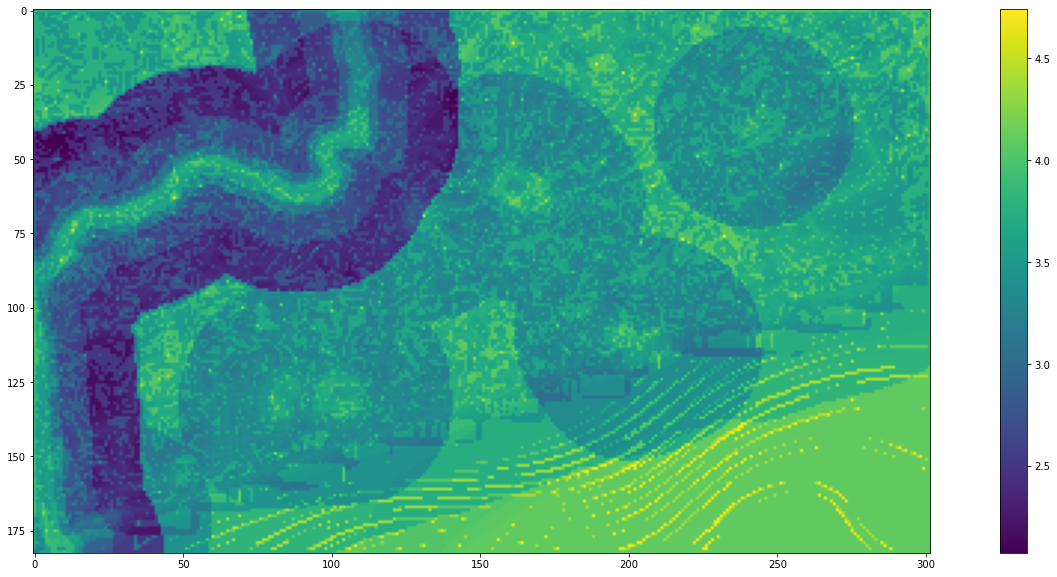

In [157]:
%matplotlib inline
plt.figure(figsize = (25,10))
plt.imshow(risk_matrix)
plt.plot()
plt.colorbar()

In [158]:
risk_matrix.min() , risk_matrix.mean(), risk_matrix.max(), risk_matrix.std()

(rdarray(2.07418856),
 rdarray(3.43242716),
 rdarray(4.74034003),
 rdarray(0.50921663))

In [159]:
risk_matrix.shape

(183, 302)

In [160]:
np.save(f"{OUTPUT}/{REGION}_risk_matrix.npy", risk_matrix)
rec_wsm= np.load(f"{OUTPUT}/{REGION}_risk_matrix.npy")

with rio.Env():
    region = rasterio.open(f"{CROPPED}/{j}_{REGION}_cropped_b4.tif")
    profile = region.profile.copy()
    profile.update({'dtype': 'float64', 'count': 1})
    
with rio.open(f'{OUTPUT}/{REGION}_risk_matrix.tif', 'w', **profile) as f:
    f.write(risk_matrix, 1)


In [161]:
!gdalwarp -tr 5 5  -r average {OUTPUT}/{REGION}_risk_matrix.tif {OUTPUT}/{REGION}_risk_matrix5m1.tif -overwrite

Creating output file that is 1818P x 1104L.
Processing production/puri/modeloutput/riskscore/output/puri_risk_matrix.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [162]:
label_rast = rio.open(f'{INTER}/{REGION}_label.tif')
label_rast.crs

CRS.from_epsg(32645)

In [163]:
risk_rast = rio.open(f'{OUTPUT}/{REGION}_risk_matrix5m1.tif')
risk_rast.crs


CRS.from_epsg(32645)

In [164]:
risk_rast.width

1818

In [165]:
del risk_rast

In [166]:
out_img, out_transform, out_meta = clip(f'{OUTPUT}/{REGION}_risk_matrix5m1.tif', f'{INTER}/{REGION}_label.tif')
dest_path = f'{OUTPUT}/{REGION}_risk_matrix5m1_clipped.tif'
with rio.open(dest_path, "w", **out_meta) as dest:
    dest.write(out_img)

    
out_img, out_transform, out_meta = clip(f'{INTER}/{REGION}_area.tif', f'{OUTPUT}/{REGION}_risk_matrix.tif')
dest_path = f'{OUTPUT}/{REGION}_area_clipped.tif'
with rio.open(dest_path, "w", **out_meta) as dest:
    dest.write(out_img)
    
out_img, out_transform, out_meta= clip(f'{INTER}/{REGION}_label.tif', f'{OUTPUT}/{REGION}_risk_matrix.tif')
dest_path = f'{OUTPUT}/{REGION}_label_clipped.tif'
with rio.open(dest_path, "w", **out_meta) as dest:
    dest.write(out_img)
            

(1, 1094, 1811)
(1, 1093, 1810)
(1, 1093, 1810)


## Footprints label and label_id assignments

#### division
RCC, CGI4s, Tile4s= Low risk

CGI2s, Tile2s = medium risk

tarpaulin, CGI1s = high risk



|label_id| label |
| --- | --- |
| 1 | RCC |
| 2 | CGI_1S |
| 3 | CGI_2S |
| 4 | CGI_4S |
| 5 | TILE_2S |
| 6 | TILE_4S |
| 7 | TARP |




In [167]:
footprints_label, footprints_label_rast = read_data_asarray(f"{INTER}/{REGION}_label.tif")
footprints_area, footprints_area_rast = read_data_asarray(f"{INTER}/{REGION}_area.tif")
rec_matrix, rec_matrix_rast = read_data_asarray(f"{OUTPUT}/{REGION}_risk_matrix5m1_clipped.tif")

In [168]:
rec_matrix_rast = rec_matrix_rast[1:, :footprints_label_rast.shape[1]]

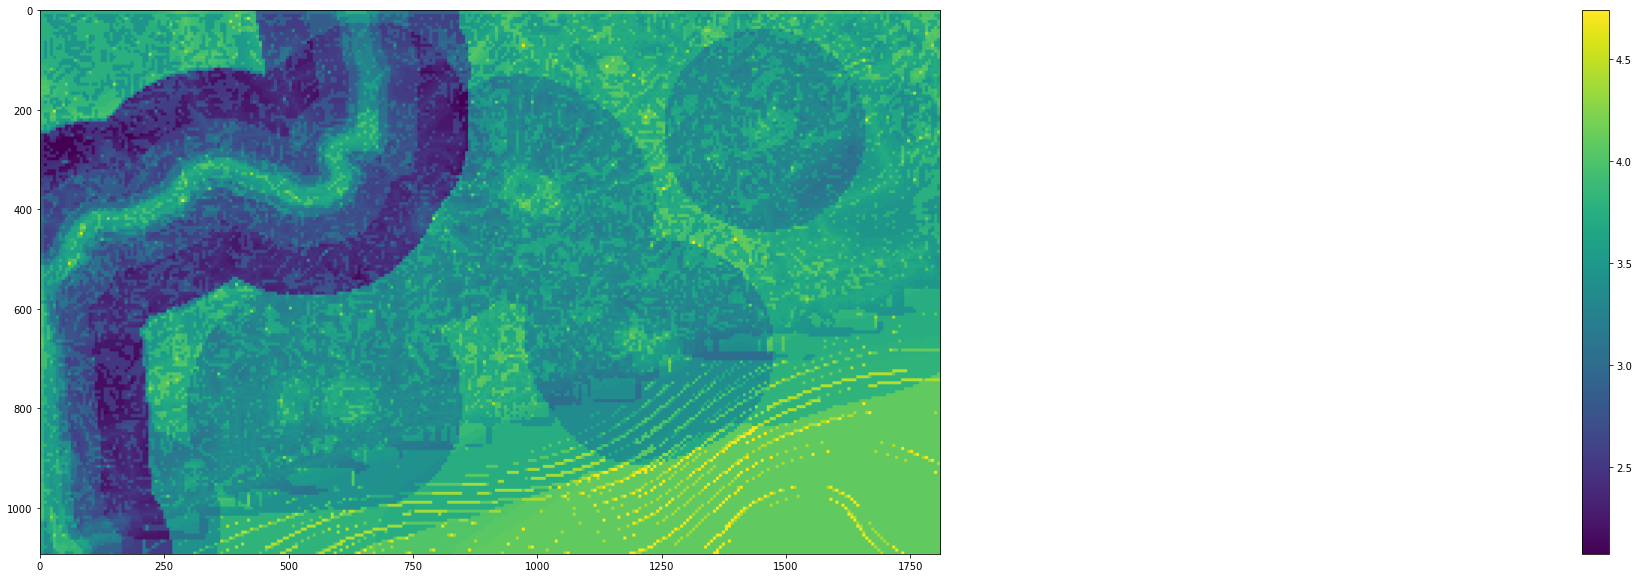

In [169]:
%matplotlib inline
plt.figure(figsize = (230,10))
plt.imshow(rec_matrix_rast)
plt.plot()
plt.colorbar()

In [170]:
#adding footprints to the overlay
rec_footprints =[]
rec_footprints_label = np.zeros_like(footprints_label_rast, dtype=np.float64)
rec_footprints_label[np.where(footprints_label_rast == 7)] = 5
rec_footprints_label[np.where((footprints_label_rast == 3) | (footprints_label_rast == 2))] = 4
rec_footprints_label[np.where(footprints_label_rast == 5)] = 3
rec_footprints_label[np.where((footprints_label_rast == 1) | (footprints_label_rast == 4) | (footprints_label_rast == 6) )] = 2
rec_footprints_label[np.where(footprints_label_rast <=0)] = 1
rec_footprints.append(footprints_label_rast)
np.save(f"{OUTPUT/REGION}_footprints_label_rast.npy", footprints_label_rast)

rec_footprints_area = np.zeros_like(footprints_area_rast, dtype=np.float64)
rec_footprints_area[np.where(footprints_area_rast > 75)] = 1
rec_footprints_area[np.where((footprints_area_rast >50) & (footprints_area_rast <= 75))] = 2
rec_footprints_area[np.where((footprints_area_rast > 30) & (footprints_area_rast <=50))] = 3
rec_footprints_area[np.where((footprints_area_rast > 15) & (footprints_area_rast <=30))] = 4
rec_footprints_area[np.where(footprints_area_rast <=15)] = 5
rec_footprints.append(rec_footprints_area)
np.save(f"{OUTPUT/REGION}_rec_footprints_area.npy", rec_footprints_area)

In [171]:
footprints_label_rast.shape

(1093, 1810)

In [172]:
rec_matrix_rast.shape, rec_footprints_label.shape, rec_footprints_area.shape

((1093, 1810), (1093, 1810), (1093, 1810))

In [173]:
re_weight_dict_risk = {'rec_matrix': 64.7, 
                     'rec_footprints_label': 21.9,
                     'rec_footprints_area':13.4 } 

final_matrix = (rec_matrix_rast*re_weight_dict_risk['rec_matrix']+
       rec_footprints_label*re_weight_dict_risk['rec_footprints_label']+  
       rec_footprints_area*re_weight_dict_risk['rec_footprints_area'])/ 100

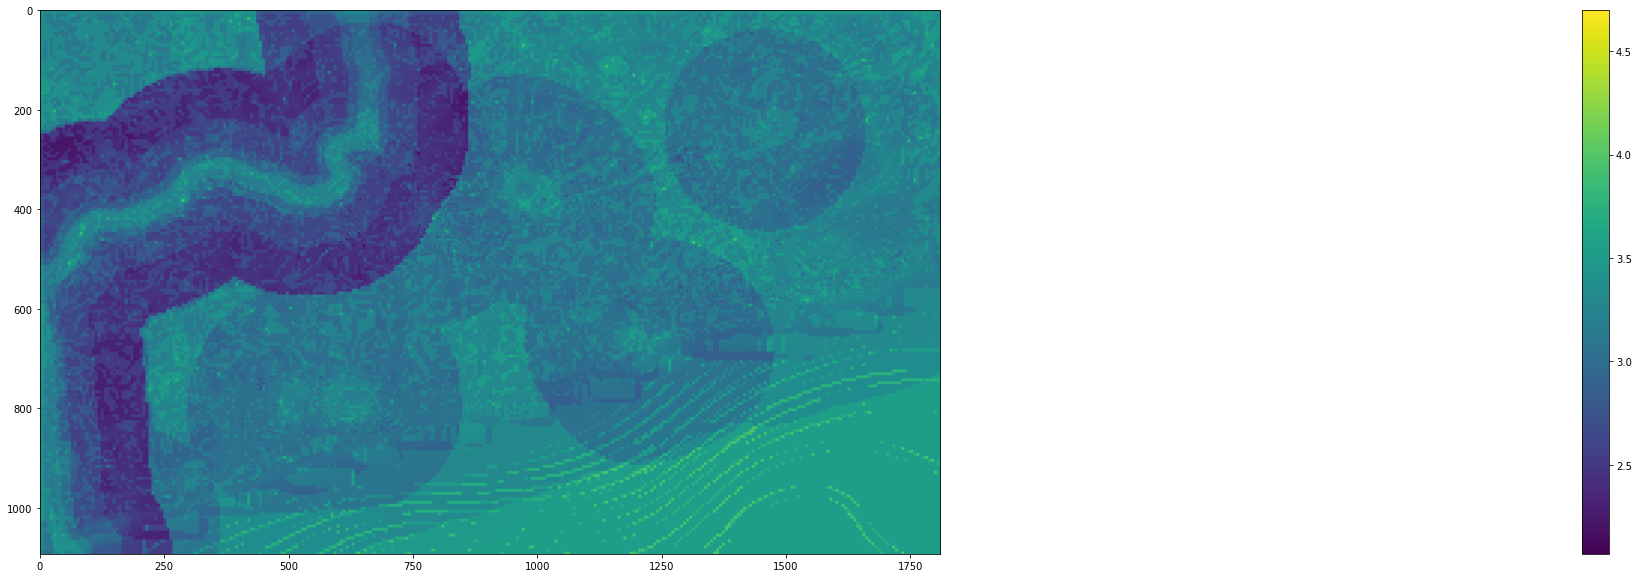

In [174]:
%matplotlib inline
plt.figure(figsize = (230,10))
plt.imshow(final_matrix)
plt.plot()
plt.colorbar()

In [175]:
final_matrix.min() , final_matrix.max()

(2.0700000000000003, 4.698)

In [176]:
final_matrix.shape

(1093, 1810)

In [177]:
#twi adjusted
rec_wsm = np.zeros_like(final_matrix,  dtype=np.float64)
rec_wsm[np.where(final_matrix <=1.5)] = 1
rec_wsm[np.where((final_matrix >1.5) & (final_matrix <2.8))] = 2
rec_wsm[np.where((final_matrix >=2.8) & (final_matrix < 3.2))] = 3
rec_wsm[np.where((final_matrix >= 3.2) & (final_matrix <=4))] = 4
rec_wsm[np.where(final_matrix >4)] = 5

# Save the output as raster

In [178]:
region= rio.open(f"{OUTPUT}/{REGION}_risk_matrix5m1_clipped.tif")
with rio.Env():
    profile = region.profile.copy()
    profile.update({'dtype': 'float64', 'count': 1})
    
    with rio.open(f"{OUTPUT}/{REGION}_final_risk_matrix5m.tif", 'w', **profile) as f:
        f.write(rec_wsm, 1)

# Resample to original 30m tif file

In [179]:
!gdalwarp -tr 30 30  -r mode {OUTPUT}/{REGION}_final_risk_matrix5m.tif {OUTPUT}/{REGION}_final_risk_matrix30m.tif -overwrite

Creating output file that is 302P x 182L.
Processing production/puri/modeloutput/riskscore/output/puri_final_risk_matrix5m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


# Create zonal statistics at house level

In [180]:
from rasterstats import zonal_stats


In [ ]:
#house_wise
!fio cat {INTER}/{REGION}_footprints_{UTM}.shp | rio zonalstats --all-touched -r {OUTPUT}/{REGION}_final_risk_matrix30m.tif --prefix "score_" >{OUTPUT}/{REGION}_house_level_{UTM}.geojson

/root/anaconda3/envs/linux_py38/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/root/anaconda3/envs/linux_py38/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/root/anaconda3/envs/linux_py38/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/root/anaconda3/envs/linux_py38/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/root/anaconda3/envs/linux_py38/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata expli

In [ ]:
house_= gpd.read_file(f"{OUTPUT}/{REGION}_house_level_{UTM}.geojson")
house_=house_.set_crs(epsg=UTM, allow_override=True)
exploded = house_.explode().reset_index()

exploded=exploded.to_crs(epsg=WGS84)


exploded.to_file(f"{OUTPUT}/{REGION}_house_level_{WGS84}.shp")
exploded.head()

In [ ]:
def get_houselevel_risk():
    house_= gpd.read_file(f"{OUTPUT}/{REGION}_house_level_{UTM}.geojson")
    house_=house_.set_crs(epsg=UTM, allow_override=True)
    exploded = house_.explode().reset_index()
    exploded=exploded.to_crs(epsg=WGS84)
    exploded.to_file(f"{OUTPUT}/{REGION}_house_level_{WGS84}.shp")
    
    house_4326 = gpd.read_file(f"{OUTPUT}/{REGION}_house_level_{WGS84}.shp")
    house_4326['risk_score'] = house_4326['score_max']
    house_4326 = house_4326[['area', 'label', 'risk_score','geometry']]
    house_4326['risk_score'] = house_4326['risk_score'].round(decimals=2)
    house_4326['area'] = house_4326['area'].round(decimals=2)
    #print(type(house))
    house_4326.to_file(f"{OUTPUT}/{REGION}_final_house_level_{WGS84}.geojson", driver="GeoJSON")

    return house_4326

In [ ]:
house_risk = get_houselevel_risk()
house_risk.tail(10)

In [ ]:
ax = sns.distplot(house_risk.risk_score.ravel(), axlabel='risk_score')
ax = plt.gca()

In [ ]:
house_risk.describe()

In [ ]:
house_risk.risk_score.value_counts()

In [ ]:
ax = sns.distplot(house_risk.label.ravel(), axlabel='label')
ax = plt.gca()

In [ ]:
house_risk.label.value_counts()

In [ ]:
house_risk.shape

In [ ]:
param_list=['rec_footprints_label', 'rec_footprints_area', 'rec_water_poly', 'rec_water_line',
           'rec_roads', 'rec_ndvi', 'rec_landslide', 'rec_twi', 'rec_impervious', 'rec_ocean', 'rec_elevation']

if not ocean.empty:
    array_list=[rec_footprints_label, rec_footprints_area, rec_water_poly, rec_water_line,
               rec_roads, rec_ndvi, rec_landslide, rec_impervious, rec_ocean, rec_elevation]
else:
    array_list=[rec_footprints_label, rec_footprints_area, rec_water_poly, rec_water_line,
               rec_roads, rec_ndvi, rec_landslide, rec_impervious, rec_elevation ]

In [ ]:
##TEST
region= rio.open(f"{OUTPUT}/{REGION}_final_risk_matrix30m.tif")
with rio.Env():
    profile = region.profile.copy()
    profile.update({'dtype': 'float64', 'count': 1})
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_roads.tif", 'w', **profile) as f:
            f.write(rec_roads, 1)    
    except:
        pass
    
    try:    
        with rio.open(f"{OUTPUT}/{REGION}_rec_water_line.tif", 'w', **profile) as f:
            f.write(rec_water_line, 1) 
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_footprints_label.tif", 'w', **profile) as f:
            f.write(rec_footprints_label, 1) 
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_footprints_area.tif", 'w', **profile) as f:
            f.write(rec_footprints_area, 1)
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_water_poly.tif", 'w', **profile) as f:
            f.write(rec_water_poly, 1)
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_ndvi.tif", 'w', **profile) as f:
            f.write(rec_ndvi, 1)
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_landslide.tif", 'w', **profile) as f:
            f.write(rec_landslide, 1)
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_impervious.tif", 'w', **profile) as f:
            f.write(rec_impervious, 1)
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_ocean.tif", 'w', **profile) as f:
            f.write(rec_ocean, 1)
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_elevation.tif", 'w', **profile) as f:
            f.write(rec_elevation, 1)
    except:
        pass
    try:
        with rio.open(f"{OUTPUT}/{REGION}_rec_twi.tif", 'w', **profile) as f:
            f.write(rec_twi, 1)
    except:
        pass

In [ ]:
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_water_line.tif --prefix "rec_water_line_" >{OUTPUT}/{REGION}_rec_water_line.geojson   
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_roads.tif --prefix "rec_roads_" >{OUTPUT}/{REGION}_rec_roads.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_water_poly.tif --prefix "rec_water_poly_" >{OUTPUT}/{REGION}_rec_water_poly.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_footprints_label.tif --prefix "rec_footprints_label_" >{OUTPUT}/{REGION}_rec_footprints_label.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_footprints_area.tif --prefix "rec_footprints_area_" >{OUTPUT}/{REGION}_rec_footprints_area.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_ndvi.tif --prefix "rec_ndvi_" >{OUTPUT}/{REGION}_rec_ndvi.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_landslide.tif --prefix "rec_landslide_" >{OUTPUT}/{REGION}_rec_landslide.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_ocean.tif --prefix "rec_ocean_" >{OUTPUT}/{REGION}_rec_ocean.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_impervious.tif --prefix "rec_impervious_" >{OUTPUT}/{REGION}_rec_impervious.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_elevation.tif --prefix "rec_elevation_" >{OUTPUT}/{REGION}_rec_elevation.geojson
# !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_twi.tif --prefix "rec_twi_" >{OUTPUT}/{REGION}_rec_twi.geojson

In [ ]:
## Test
waterline_file = Path(f'{OUTPUT}/{REGION}_rec_water_line.geojson')


if not waterline_file.exists():
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_water_line.tif --prefix "rec_water_line_" >{OUTPUT}/{REGION}_rec_water_line.geojson   
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_roads.tif --prefix "rec_roads_" >{OUTPUT}/{REGION}_rec_roads.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_water_poly.tif --prefix "rec_water_poly_" >{OUTPUT}/{REGION}_rec_water_poly.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_footprints_label.tif --prefix "rec_footprints_label_" >{OUTPUT}/{REGION}_rec_footprints_label.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_footprints_area.tif --prefix "rec_footprints_area_" >{OUTPUT}/{REGION}_rec_footprints_area.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_ndvi.tif --prefix "rec_ndvi_" >{OUTPUT}/{REGION}_rec_ndvi.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_landslide.tif --prefix "rec_landslide_" >{OUTPUT}/{REGION}_rec_landslide.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_ocean.tif --prefix "rec_ocean_" >{OUTPUT}/{REGION}_rec_ocean.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_impervious.tif --prefix "rec_impervious_" >{OUTPUT}/{REGION}_rec_impervious.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_elevation.tif --prefix "rec_elevation_" >{OUTPUT}/{REGION}_rec_elevation.geojson
    !fio cat {INTER}/{REGION}_footprints_{UTM}.geojson| rio zonalstats --all-touched -r {OUTPUT}/{REGION}_rec_twi.tif --prefix "rec_twi_" >{OUTPUT}/{REGION}_rec_twi.geojson
else:
    pass
         

In [ ]:
data_frames=[]
for i, j in enumerate(param_list):
    rec_gdf=gpd.read_file(f'{OUTPUT}/{REGION}_{j}.geojson')
    rec_gdf=rec_gdf[['id', f'{j}_max', f'{j}_mean']]
    data_frames.append(rec_gdf)

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['id']), data_frames)

house_risk['id_0'] = np.arange(house_risk.shape[0])
df_merged['id_0'] = np.arange(df_merged.shape[0])
df_merge_all = pd.merge(house_risk, df_merged, on='id_0')

In [ ]:
df_merge_all=df_merge_all[['id', 'area', 'label', 'risk_score', 'geometry',
       'rec_footprints_label_max', 'rec_footprints_area_max','rec_water_poly_max', 'rec_water_line_max', 'rec_roads_max', 
        'rec_ndvi_max','rec_landslide_max','rec_impervious_max', 'rec_ocean_max', 'rec_elevation_max', 'rec_twi_max']]

In [ ]:
df_merge_all.to_file(f'{OUTPUT}/{REGION}_floodrisks_allparam.geojson', driver='GeoJSON')

# Convert to MBtiles:

In [ ]:
#converts the geojson file to mbtiles file 
if not Path(f'{OUTPUT}/{REGION}_heatwaverisks_allparam.mbtiles').exists():
    os.system(f"tippecanoe -o {OUTPUT}/{REGION}_floodrisks_allparam.mbtiles {OUTPUT}/{REGION}_floodrisks_allparam.geojson -l {REGION}")
else:
    pass

# Update Analytics

In [ ]:
# LOCATIONS = Path(OUTPUT[1])
# os.makedirs(LOCATIONS, exist_ok=True)

# hazard_df = pd.read_csv(GLOBAL/'hazard_locations.csv')
# hazard_df=hazard_df[['aoi_name', 'lat', 'long', 'hazard_type']]
region_boundary = gpd.read_file(f'{INTER/REGION}_boundary.geojson')
aoi=region_boundary.to_crs(epsg=UTM)
aoi['area']=aoi.area
df_area=aoi[['area']]
df_area.to_csv(f'{OUTPUT}/{REGION}_area.csv')

In [ ]:
df_merge_all['centroid']=df_merge_all.centroid
df_merge_all['lon'] = df_merge_all.centroid.x
df_merge_all['lat'] = df_merge_all.centroid.y

In [ ]:
if not Path(f'{OUTPUT}/{REGION}_hazard_locations.csv').exists():
    hazard_df=pd.DataFrame()
    data = {'aoi_name': [REGION],
            'lat': [df_merge_all.lat[0]],
           'long': [df_merge_all.lon[0]],
           'hazard_type':['flood']}
    hazard_df=pd.DataFrame(data)
    hazard_df.to_csv(f'{OUTPUT}/{REGION}_hazard_locations.csv')
else:
    hazard_df=pd.read_csv(f'{OUTPUT}/{REGION}_hazard_locations.csv')   
    if hazard_df.hazard_type.str.contains('flood').any():
        pass
    else:
        hazard_df.loc[len(hazard_df.aoi_name)] = [REGION, gdf.lat[0], gdf.lon[0], 'flood']

In [ ]:
# hazard_df=pd.DataFrame()
# data = {'aoi_name': [REGION],
#         'lat': [df_merge_all.lat[0]],
#        'long': [df_merge_all.lon[0]],
#        'hazard_type':['flood']}
# hazard_df=pd.DataFrame(data)
# hazard_df.to_csv(f'{OUTPUT}/{REGION}_hazard_locations.csv')
# hazard_df

In [ ]:
df_merged=df_merge_all.groupby(['risk_score']).size().reset_index(name='counts')
df_merged.to_csv(f'{OUTPUT}/{REGION}_flood_analytics.csv')